![Py4Eng](../logo.png)

# Feed Forward Network with PyTorch
## Yoav Ram

In this session we will understand:
- what is PyTorch
- how to use PyTorch to construct and train a feed forward network
- how to save trained models and then load them to re-train or predict with them



# PyTorch

[PyTorch](https://pytorch.org/) is an open-source machine learning framework that provides a flexible tensor library and a deep learning platform with eager execution and a clear imperative programming model.

We will implement the same simple MNIST feed-forward example here using PyTorch, including data loading, model definition, training loop, saving/loading, and simple diagnostics.

<img src="https://pytorch.org/assets/images/pytorch-logo.png" style="height: 80px; width: auto;">

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
print('PyTorch:', torch.__version__, 'CUDA available:', torch.cuda.is_available())

PyTorch: 2.7.1 CUDA available: False


# Classifying images

We'll load MNIST using torchvision and create DataLoaders for training and testing.


In [42]:
# Download / load MNIST (will be stored under ../data)
transform = transforms.ToTensor()  # converts to [0,1] floats and adds channel dim
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)
batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [43]:
# MNIST images are 28x28; torchvision's ToTensor produced shape (1,28,28)
nfeatures = 28 * 28
device = torch.device(
    'cuda' if torch.cuda.is_available() else 
    'mps' if torch.backends.mps.is_available() else 
    'cpu'
)
print('device =', device)

device = mps


The dataset loader already converts image pixels to floats between 0 and 1. For PyTorch's CrossEntropyLoss we keep labels as integer class indices (no one-hot encoding).

In [44]:
ncats = 10  # MNIST has 10 classes

The images are 1-channel 28x28 tensors (flattened to 784 when passed to a linear layer). Labels are integer indices 0-9.

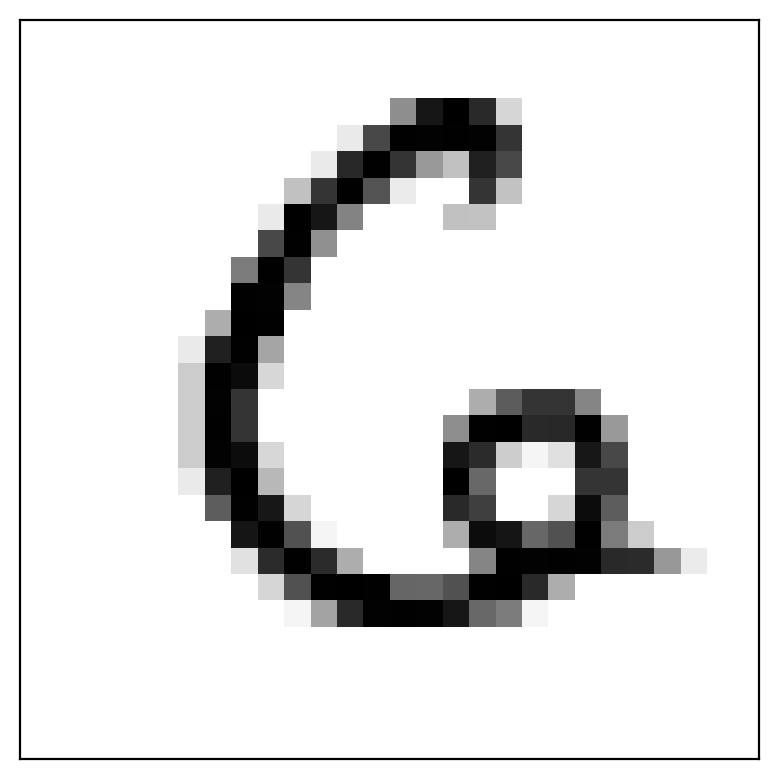

In [45]:
def display_image_tensor(t):
    # t shape: (1,28,28) or (28,28)
    im = t.squeeze().numpy() if isinstance(t, torch.Tensor) else t
    plt.imshow(im, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])

# show an example from train dataset
display_image_tensor(train_dataset[910][0])

# Softmax (linear) model

Reminder: 
$$
\hat{y}_i = softmax(W x_i)
$$

We'll implement the same using a simple PyTorch `Module` with a flatten + linear layer. Training uses `CrossEntropyLoss` which combines `log-softmax` and `NLL` loss.

In [46]:
class SoftmaxModel(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.lin = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.flatten(x)
        return self.lin(x)  # logits - not probabilities

model = SoftmaxModel(nfeatures, ncats).to(device)
print(model)

SoftmaxModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin): Linear(in_features=784, out_features=10, bias=True)
)


Next, set up the loss function and optimizer for training.

In [47]:
loss_fn = nn.CrossEntropyLoss()  # applies log-softmax
optimizer = optim.SGD(model.parameters(), lr=0.1)

We define the train and evaluate functions.

In [49]:
def train_model(model, loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return running_loss / total, correct / total

def eval_model(model, loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)
            running_loss += loss.item() * X.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return running_loss / total, correct / total


Now for the training loop:

In [50]:
tic = time()
n_epochs = 30
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
for epoch in range(n_epochs):
    train_loss, train_acc = train_model(model, train_loader, loss_fn, optimizer, device)
    val_loss, val_acc = eval_model(model, test_loader, loss_fn, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f'Epoch {epoch+1}/{n_epochs} - train_acc: {train_acc:.4f} val_acc: {val_acc:.4f}')
toc = time()
print(f'Training complete in {toc - tic:.0f} seconds')

Epoch 1/30 - train_acc: 0.8814 val_acc: 0.9110
Epoch 2/30 - train_acc: 0.9084 val_acc: 0.9176
Epoch 3/30 - train_acc: 0.9142 val_acc: 0.9189
Epoch 4/30 - train_acc: 0.9168 val_acc: 0.9201
Epoch 5/30 - train_acc: 0.9189 val_acc: 0.9214
Epoch 6/30 - train_acc: 0.9204 val_acc: 0.9199
Epoch 7/30 - train_acc: 0.9218 val_acc: 0.9211
Epoch 8/30 - train_acc: 0.9227 val_acc: 0.9228
Epoch 9/30 - train_acc: 0.9234 val_acc: 0.9225
Epoch 10/30 - train_acc: 0.9239 val_acc: 0.9239
Epoch 11/30 - train_acc: 0.9245 val_acc: 0.9236
Epoch 12/30 - train_acc: 0.9253 val_acc: 0.9211
Epoch 13/30 - train_acc: 0.9264 val_acc: 0.9229
Epoch 14/30 - train_acc: 0.9265 val_acc: 0.9219
Epoch 15/30 - train_acc: 0.9262 val_acc: 0.9235
Epoch 16/30 - train_acc: 0.9268 val_acc: 0.9249
Epoch 17/30 - train_acc: 0.9270 val_acc: 0.9246
Epoch 18/30 - train_acc: 0.9278 val_acc: 0.9254
Epoch 19/30 - train_acc: 0.9283 val_acc: 0.9243
Epoch 20/30 - train_acc: 0.9286 val_acc: 0.9257
Epoch 21/30 - train_acc: 0.9286 val_acc: 0.9256
E

Save the model and the training history:

In [51]:
# Save state_dict and history
torch.save(model.state_dict(), '../data/torch_ffn_model.pth')
with open('../data/torch_ffn_history.p', 'wb') as f:
    pickle.dump(history, f)

Load the model and the history:

In [52]:
# reload model weights into a fresh model instance
model = SoftmaxModel(nfeatures, ncats).to(device)
model.load_state_dict(torch.load('../data/torch_ffn_model.pth', map_location=device))
with open('../data/torch_ffn_history.p', 'rb') as f:
    history = pickle.load(f)

Next, plot the training history.

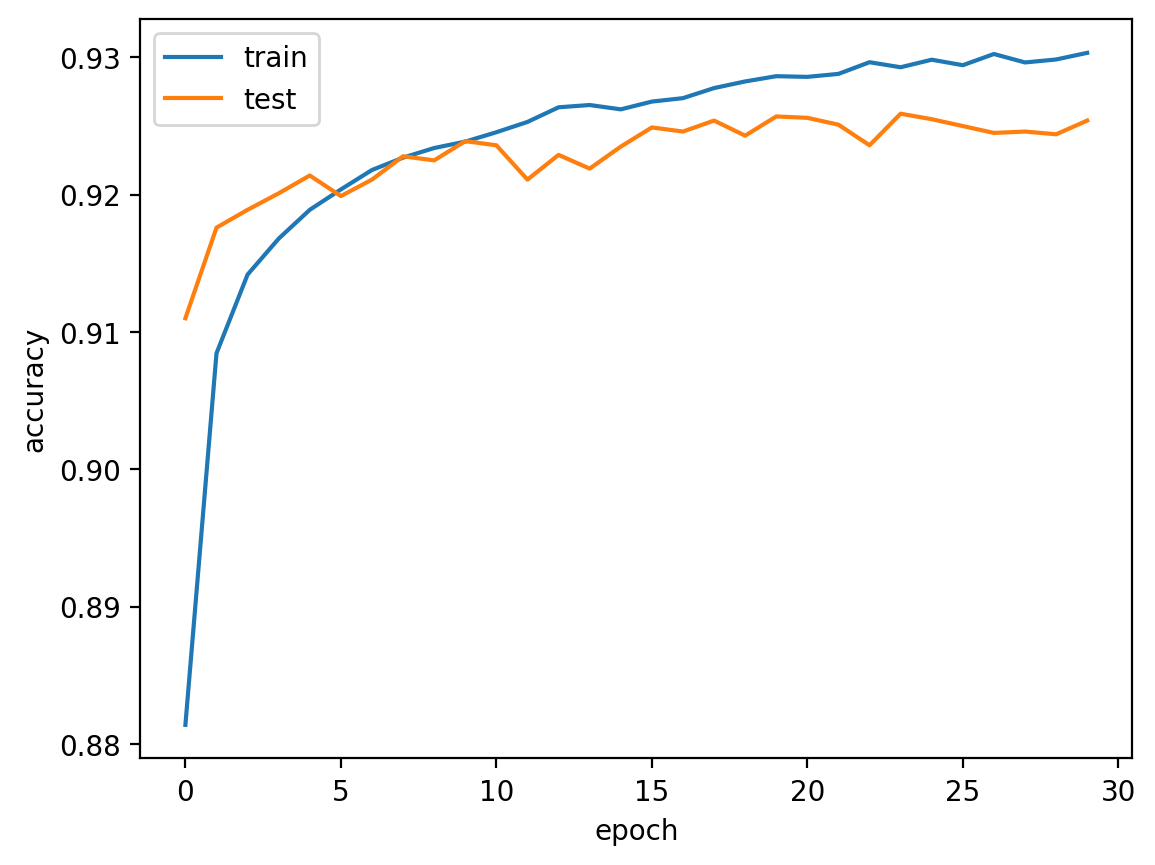

In [53]:
def plot_history(history):
    plt.plot(history['train_acc'], label='train')
    plt.plot(history['val_acc'], label='test')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

plot_history(history)

We can also use the model to make predictions:

Truth: 7, Prediction: 7 (0.9966)


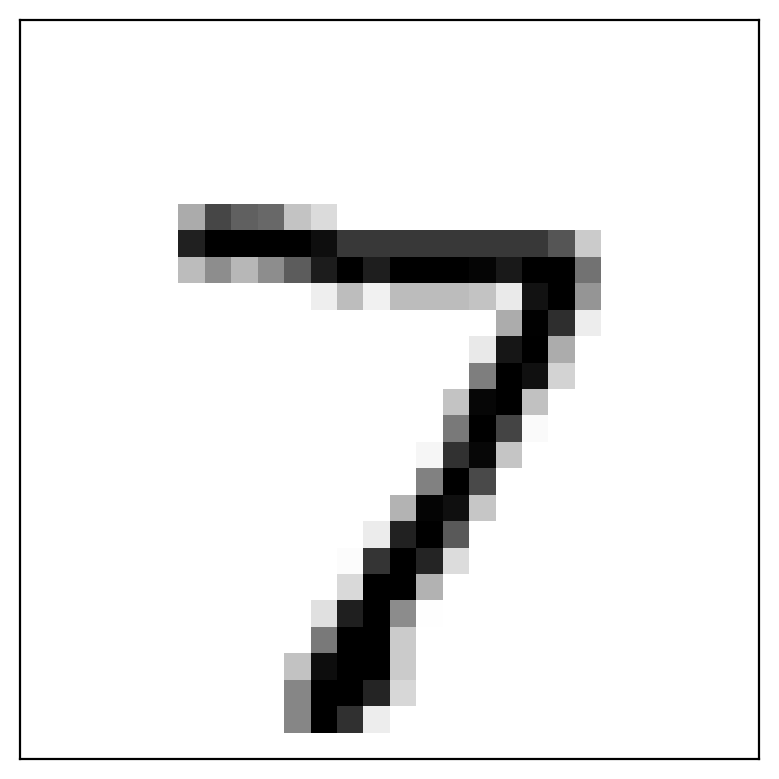

In [54]:
# pick a test example
idx = 0
img, label = test_dataset[idx]
display_image_tensor(img)
model.eval()
with torch.no_grad():
    logits = model(img.unsqueeze(0).to(device))
    probs = F.softmax(logits, dim=1)
    pred = probs.argmax(dim=1).item()
    conf = probs.max().item()
print(f'Truth: {label}, Prediction: {pred} ({conf:.4f})')

Can we believe the probability that the model outputs?
We compute the probabilities for test set and compare correct vs incorrect.

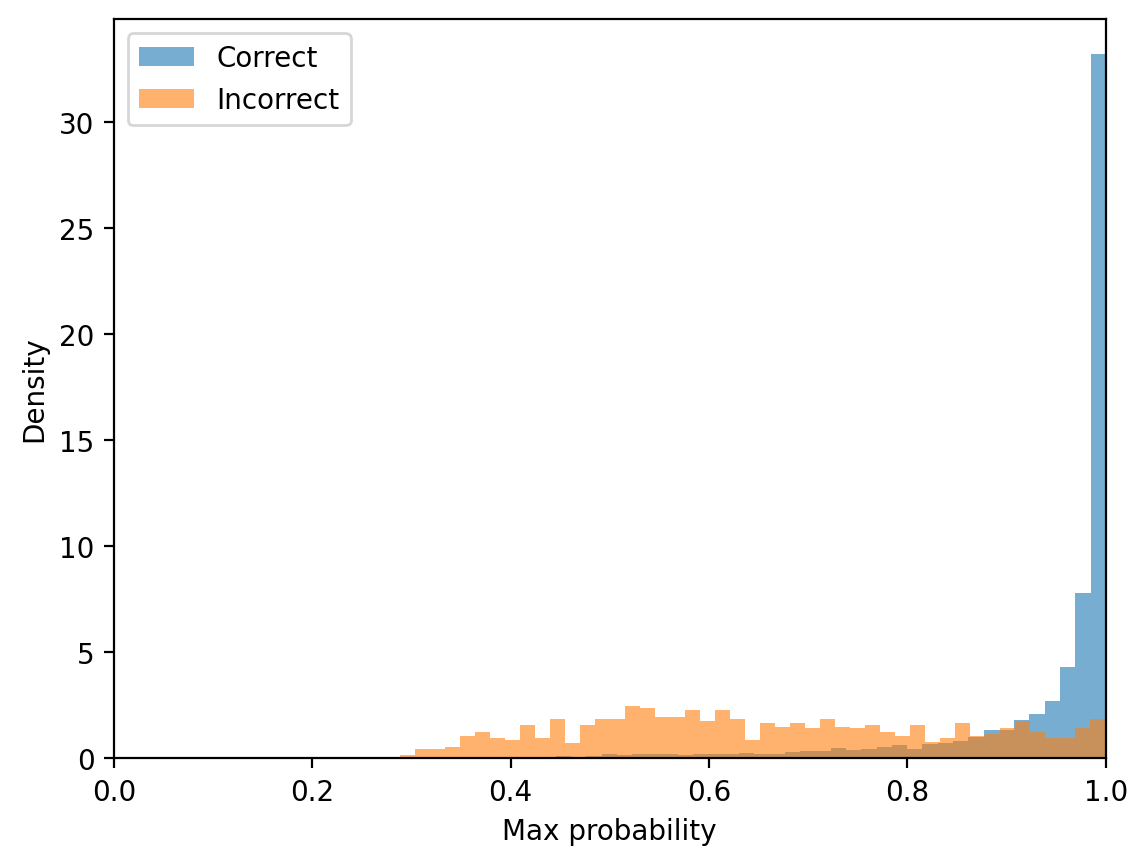

In [55]:
model.eval()
probs_list = []
labels_list = []
with torch.no_grad():
    for X, y in test_loader:
        logits = model(X.to(device))
        probs = F.softmax(logits, dim=1).cpu().numpy()
        probs_list.append(probs)
        labels_list.append(y.numpy())
probs_all = np.vstack(probs_list)
labels_all = np.concatenate(labels_list)
preds = probs_all.argmax(axis=1)
correct_mask = preds == labels_all
plt.hist(probs_all[correct_mask].max(axis=1), bins=50, density=True, alpha=0.6, label='Correct')
plt.hist(probs_all[~correct_mask].max(axis=1), bins=50, density=True, alpha=0.6, label='Incorrect')
plt.xlim(0,1)
plt.xlabel('Max probability')
plt.ylabel('Density')
plt.legend();

# Exercise: Feed forward with one hidden layer

Let's add a hidden layer so that we have: 
$$
x^{(2)}_i = ReLU(W^{(1)} x^{(1)}_i) \\
\hat{y}_i = softmax(W^{(2)} x^{(2)}_i)
$$

Create a new PyTorch Module with one hidden layer, train it, and use the Adam optimizer instead of SGD.
Save the model and history to `../data/torch_ffn2_model.pth` and `../data/torch_ffn2_history.p`.

A solution is available in `../solutions/T_FFN.ipynb`.

In [ ]:
class TwoLayerFFN(nn.Module):
    def __init__(self, in_features, hidden, out_features):
        super().__init__()
        # your code here: define layers

    def forward(self, x):
        # your code here: apply layers

In [ ]:
hidden = # choose this
model = TwoLayerFFN(nfeatures, hidden, ncats).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
n_epochs = 20
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
tic = time()
for epoch in range(n_epochs):
    tr_loss, tr_acc = train_model(model, train_loader, loss_fn, optimizer, device)
    val_loss, val_acc = eval_model(model, test_loader, loss_fn, device)
    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f'Epoch {epoch+1}/{n_epochs} - train_acc: {tr_acc:.4f} val_acc: {val_acc:.4f}')
toc = time()
print(f'Training complete in {toc - tic:.0f} seconds')

# Save the two-layer model and its history
torch.save(model.state_dict(), '../data/torch_ffn2_model.pth')
with open('../data/torch_ffn2_history.p', 'wb') as f:
    pickle.dump(history, f)

Epoch 1/20 - train_acc: 0.9106 val_acc: 0.9475
Epoch 2/20 - train_acc: 0.9563 val_acc: 0.9630
Epoch 3/20 - train_acc: 0.9705 val_acc: 0.9671
Epoch 4/20 - train_acc: 0.9773 val_acc: 0.9742
Epoch 5/20 - train_acc: 0.9819 val_acc: 0.9770
Epoch 6/20 - train_acc: 0.9861 val_acc: 0.9779
Epoch 7/20 - train_acc: 0.9888 val_acc: 0.9770
Epoch 8/20 - train_acc: 0.9911 val_acc: 0.9785
Epoch 9/20 - train_acc: 0.9928 val_acc: 0.9791
Epoch 10/20 - train_acc: 0.9941 val_acc: 0.9784
Epoch 11/20 - train_acc: 0.9960 val_acc: 0.9796
Epoch 12/20 - train_acc: 0.9959 val_acc: 0.9748
Epoch 13/20 - train_acc: 0.9966 val_acc: 0.9778
Epoch 14/20 - train_acc: 0.9969 val_acc: 0.9782
Epoch 15/20 - train_acc: 0.9973 val_acc: 0.9739
Epoch 16/20 - train_acc: 0.9971 val_acc: 0.9783
Epoch 17/20 - train_acc: 0.9987 val_acc: 0.9789
Epoch 18/20 - train_acc: 0.9986 val_acc: 0.9780
Epoch 19/20 - train_acc: 0.9980 val_acc: 0.9797
Epoch 20/20 - train_acc: 0.9989 val_acc: 0.9787
Training complete in 74 seconds


Final test accuracy 0.9787


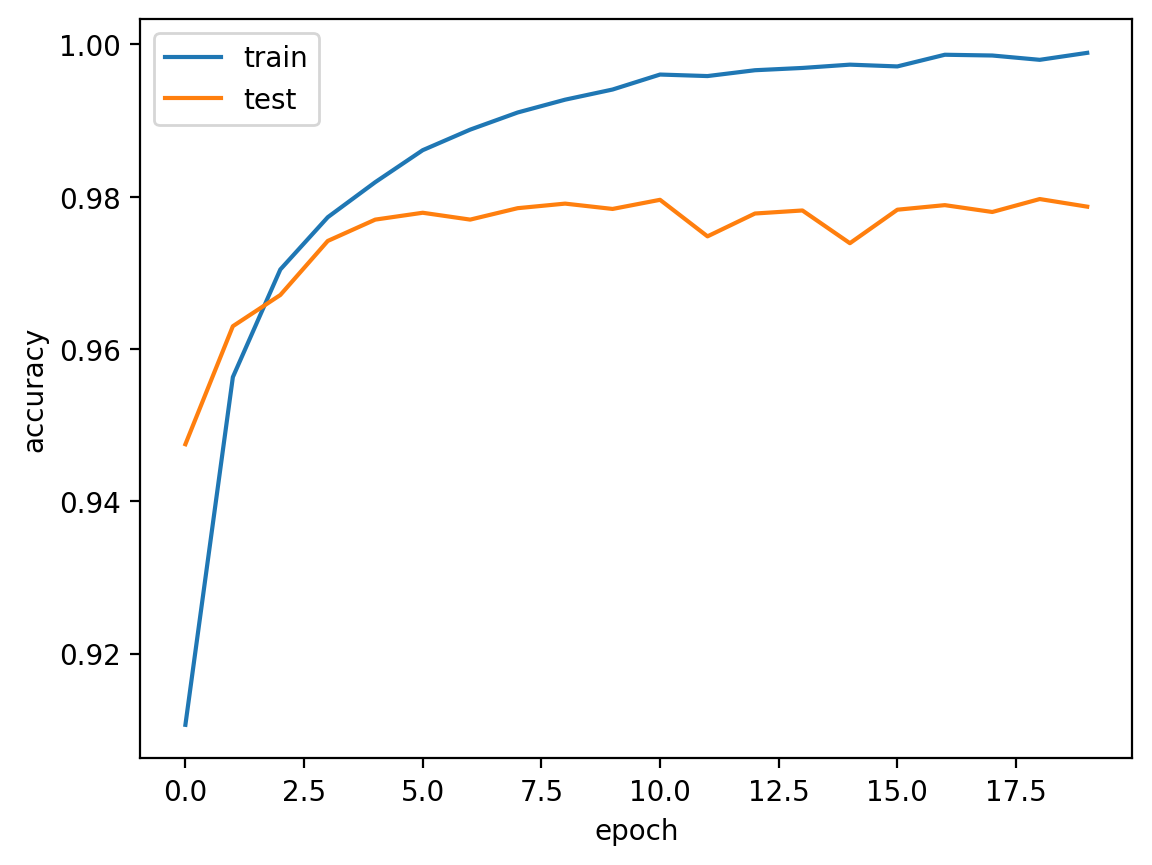

In [ ]:
plot_history(history)
print(f"Final test accuracy {history['val_acc'][-1]:.4f}")

Let's load the model and use it to classify a single image.

Loaded model test accuracy: 0.9787, loss: 0.0929
Truth: 1, Prediction: 1 (0.9989)


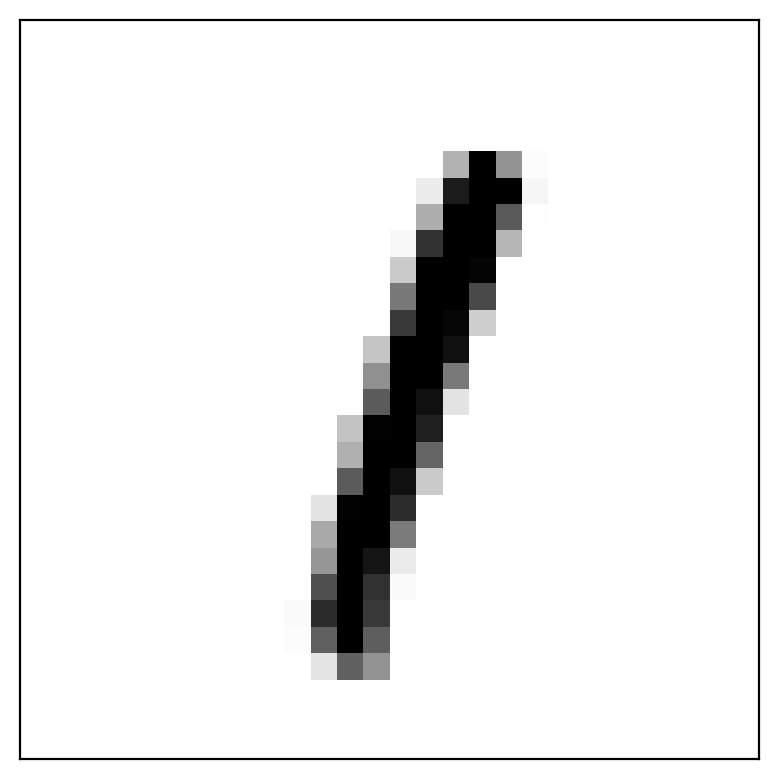

In [ ]:
model = TwoLayerFFN(nfeatures, hidden, ncats).to(device)
model.load_state_dict(torch.load('../data/torch_ffn2_model.pth', map_location=device))
val_loss, val_acc = eval_model(model, test_loader, loss_fn, device)
print(f'Loaded model test accuracy: {val_acc:.4f}, loss: {val_loss:.4f}')

# show a sample prediction
idx = 5
img, label = test_dataset[idx]
display_image_tensor(img)
model.eval()
with torch.no_grad():
    logits = model(img.unsqueeze(0).to(device))
    probs = F.softmax(logits, dim=1)
    pred = probs.argmax(dim=1).item()
    conf = probs.max().item()
print(f'Truth: {label}, Prediction: {pred} ({conf:.4f})')

Now let's look at the train and test accuracy.

# References

- PyTorch docs: https://pytorch.org/
- TorchVision datasets and transforms: https://pytorch.org/vision/stable/index.html

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)